# Question 1.1

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('A1_co2.txt', sep=" ")
df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [22]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

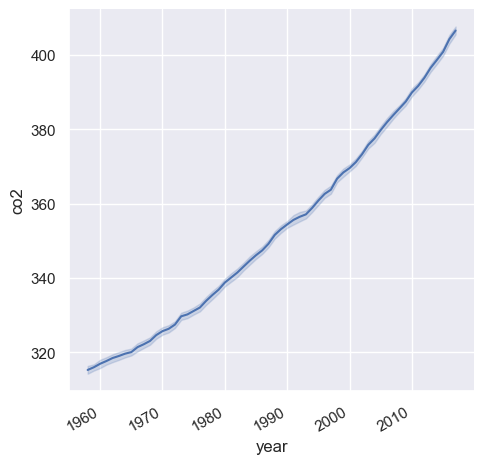

In [34]:
# TODO: Plot test and train set together

import seaborn as sns

# Plot the train set
g = sns.relplot(x="year", y="co2", kind="line", data=train)
g.fig.autofmt_xdate()



# Question 1.2

In [35]:
min_date = df['year'].min()
max_date = df['year'].max()
print(min_date, max_date)

1958 2019


## Question 1.2.1

In [60]:
DAYS_PER_YEAR = 365.2425
X = np.vstack(
    [
        np.ones_like(train["time"]),
        train["time"],
        np.sin(2 * np.pi / DAYS_PER_YEAR * train["time"]),
        np.cos(2 * np.pi / DAYS_PER_YEAR * train["time"]),
    ]
).T

In [61]:
y = train["co2"].values

In [62]:
beta_hat, _, _, _ = np.linalg.lstsq(X, y)
beta_hat

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_63929/2767225113.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat, _, _, _ = np.linalg.lstsq(X, y)


array([-2.64967724e+03,  1.55185835e+00, -2.94675923e+01,  8.11796721e+01])

## Question 1.2.2

In [64]:
N, p = X.shape

residuals = y - X @ beta_hat

sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

4.9267581314142985

In [66]:
beta_hat_var = sigma_hat2 * np.linalg.inv(X.T @ X)
beta_hat_var

array([[ 6.64487481e+05, -3.34233119e+02, -1.86937130e+04,
        -6.96699750e+03],
       [-3.34233119e+02,  1.68118265e-01,  9.40211352e+00,
         3.50643966e+00],
       [-1.86937130e+04,  9.40211352e+00,  5.26448908e+02,
         1.94629814e+02],
       [-6.96699750e+03,  3.50643966e+00,  1.94629814e+02,
         7.71570742e+01]])

<AxesSubplot: >

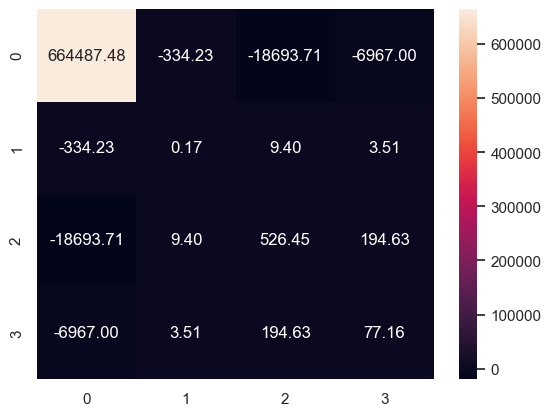

In [67]:
# Heatmap of the variance of the coefficients
sns.heatmap(beta_hat_var, annot=True, fmt=".2f")

## Question 1.2.3

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_63929/3864881612.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


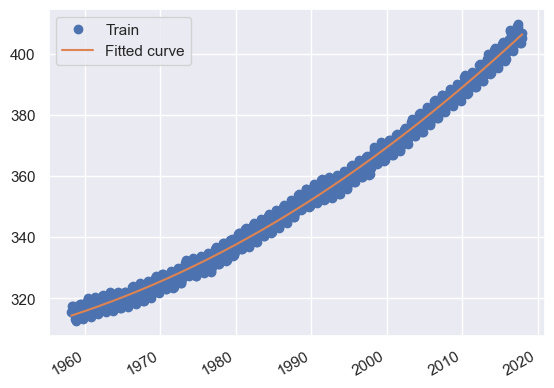

In [70]:
t = np.linspace(min(train["time"]), max(train["time"]), 1000)
X_t = np.vstack(
    [
        np.ones_like(t),
        t,
        np.sin(2 * np.pi / DAYS_PER_YEAR * t),
        np.cos(2 * np.pi / DAYS_PER_YEAR * t),
    ]
).T

y_hat = X_t @ beta_hat

# Plot the train set and the fitted curve

fig, ax = plt.subplots()
ax.plot(train["time"], train["co2"], "o", label="Train")
ax.plot(t, y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()